In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import random as rand
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.api as sm

In [2]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [3]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
base_path = Path('/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

image_num = str(79)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))


In [5]:
#So track IDs and corrresponding tracks are found in tracking df, 
#The corresponding points that made the circle are in arcos df, 
#the waves to analze are in waves df, need to go from 
#WaveDF --> arcosDF --> trackingDF 
#Get centroid and radius over time from waveDF, 
#Get trackID inside wavefront from arcosDF, 
#Get track from tracking, then calc radial movement as enter wavefront? 

#Calc a stable centroid: 
#Only looking at clID that hvae waves mapped to them for now...

clIDs = wave_df.clTrackID.values

wave_ex = wave_df[wave_df.clTrackID == clIDs[0]]
arcos_ex =  arcos_df[arcos_df.clTrackID == clIDs[0]]

centroids = np.stack(wave_ex.wave_centroid.values, axis=0)
mean_centroid = (np.mean(centroids[:,0]), np.mean(centroids[:,1]))

#get the tracks that arcos says are inside the wave...
track_collect_all_in_any_wave = []

tracks = tracking_df.groupby('track_id')

for i, track in tqdm(tracks): 
    if i not in arcos_df.track_id.unique():
        track['length'] = len(track)
        track_collect_all_in_any_wave.append(track)

tracks_in_all_arcos = pd.concat(track_collect_all_in_any_wave, ignore_index=True)
print('There are {} tracks across all arcos events...'.format(str(len(tracks_in_all_arcos.track_id.unique()))))

arcos_whole_duration_track_collect = []
min_track_duration = 36 #3min

for tid, track in tracks_in_all_arcos.groupby('track_id'):
    if len(track) > min_track_duration:
        #Get the time, x, and y points, but DO NOT SMOOTH here. 
        #Smoothing for this aligned measurement brings forward the movement in time 
        #This confuses what we are getting at here, so do not smooth in time.
        time = track.timepoint.values*5.0

        #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
        coords = np.stack((np.array(track.x.values), np.array(track.y.values)), axis=1)
        lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
        radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
        dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
        inst_radial_step = [dist_from_center[i+1] - dist_from_center[i] for i in range(len(dist_from_center)-1)]
        velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
        angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
        cis = np.cos(angles)
        radial_velocity = velocity*cis

        #Integrate calcium signal over mean?
        int_cal = np.sum(track['Calcium'] - track['Calcium'].mean())

        #Append the relevant parameters to the track: 
        track['radial_dist'] = dist_from_center
        track['inst_radial_movement'] = np.insert(inst_radial_step, 0, float('nan'), axis=0)
        track['max_radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
        track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
        track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
        track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
        arcos_whole_duration_track_collect.append(track)

arcos_duration_tracks_DF = pd.concat(arcos_whole_duration_track_collect, ignore_index=True)

wave_start_times = []

for wid, wave_event in wave_df.groupby('clTrackID'):
    wave_start_times.append(wave_event.timepoint.min())

    
swarm_start = min(wave_start_times)
radial_movement_integration = 0.0

coll_timepoints = []
radial_collection = []
start_integration_t = 60 #Cut off 5min at start of video to eliminate drift as cells settle into frame

for t, time_slice in arcos_duration_tracks_DF.groupby('timepoint'):
    if t > start_integration_t:
        radial_movement_integration -= np.nansum(time_slice.inst_radial_movement.values)
        coll_timepoints.append((5.0/60.0)*(t - swarm_start))
        radial_collection.append(radial_movement_integration)

#Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:

event_sizes = []
event_start_stops = []
event_areas = []

for clID, clEvent in wave_df.groupby('clTrackID'):

    event_start_stops.append((np.min(clEvent.timepoint.values), np.max(clEvent.timepoint.values)))
    event_areas.append(np.pi*(clEvent.circle_radius.max()**2))
    event_sizes.append(clEvent.circle_radius.max())




100%|███████████████████████████████████| 36147/36147 [00:20<00:00, 1771.82it/s]


There are 30334 tracks across all arcos events...


In [10]:
#get the tracks that arcos says are inside the wave...
track_collect_all_in_any_wave = []

tracks = tracking_df.groupby('track_id')

for i, track in tqdm(tracks): 
    if i in arcos_df.track_id.unique():
        track['length'] = len(track)
        track_collect_all_in_any_wave.append(track)

tracks_in_all_arcos = pd.concat(track_collect_all_in_any_wave, ignore_index=True)
print('There are {} tracks across all arcos events...'.format(str(len(tracks_in_all_arcos.track_id.unique()))))

arcos_whole_duration_track_collect = []
min_track_duration = 36 #3min

for tid, track in tracks_in_all_arcos.groupby('track_id'):
    if len(track) > min_track_duration:
        #Get the time, x, and y points, but DO NOT SMOOTH here. 
        #Smoothing for this aligned measurement brings forward the movement in time 
        #This confuses what we are getting at here, so do not smooth in time.
        time = track.timepoint.values*5.0

        #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
        coords = np.stack((np.array(track.x.values), np.array(track.y.values)), axis=1)
        lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
        radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
        dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
        inst_radial_step = [dist_from_center[i+1] - dist_from_center[i] for i in range(len(dist_from_center)-1)]
        velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
        angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
        cis = np.cos(angles)
        radial_velocity = velocity*cis

        #Integrate calcium signal over mean?
        int_cal = np.sum(track['Calcium'] - track['Calcium'].mean())

        #Append the relevant parameters to the track: 
        track['radial_dist'] = dist_from_center
        track['inst_radial_movement'] = np.insert(inst_radial_step, 0, float('nan'), axis=0)
        track['max_radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
        track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
        track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
        track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
        arcos_whole_duration_track_collect.append(track)

arcos_duration_tracks_DF = pd.concat(arcos_whole_duration_track_collect, ignore_index=True)

wave_start_times = []

for wid, wave_event in wave_df.groupby('clTrackID'):
    wave_start_times.append(wave_event.timepoint.min())

    
swarm_start = min(wave_start_times)
radial_movement_integration = 0.0

coll_timepoints = []
radial_collection_inside = []
start_integration_t = 60 #Cut off 5min at start of video to eliminate drift as cells settle into frame

for t, time_slice in arcos_duration_tracks_DF.groupby('timepoint'):
    if t > start_integration_t:
        radial_movement_integration -= np.nansum(time_slice.inst_radial_movement.values)
        coll_timepoints.append((5.0/60.0)*(t - swarm_start))
        radial_collection_inside.append(radial_movement_integration)


100%|███████████████████████████████████| 36147/36147 [00:15<00:00, 2346.66it/s]


There are 5813 tracks across all arcos events...


In [11]:
arcos_duration_tracks_DF.track_id.nunique()

5096

In [12]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

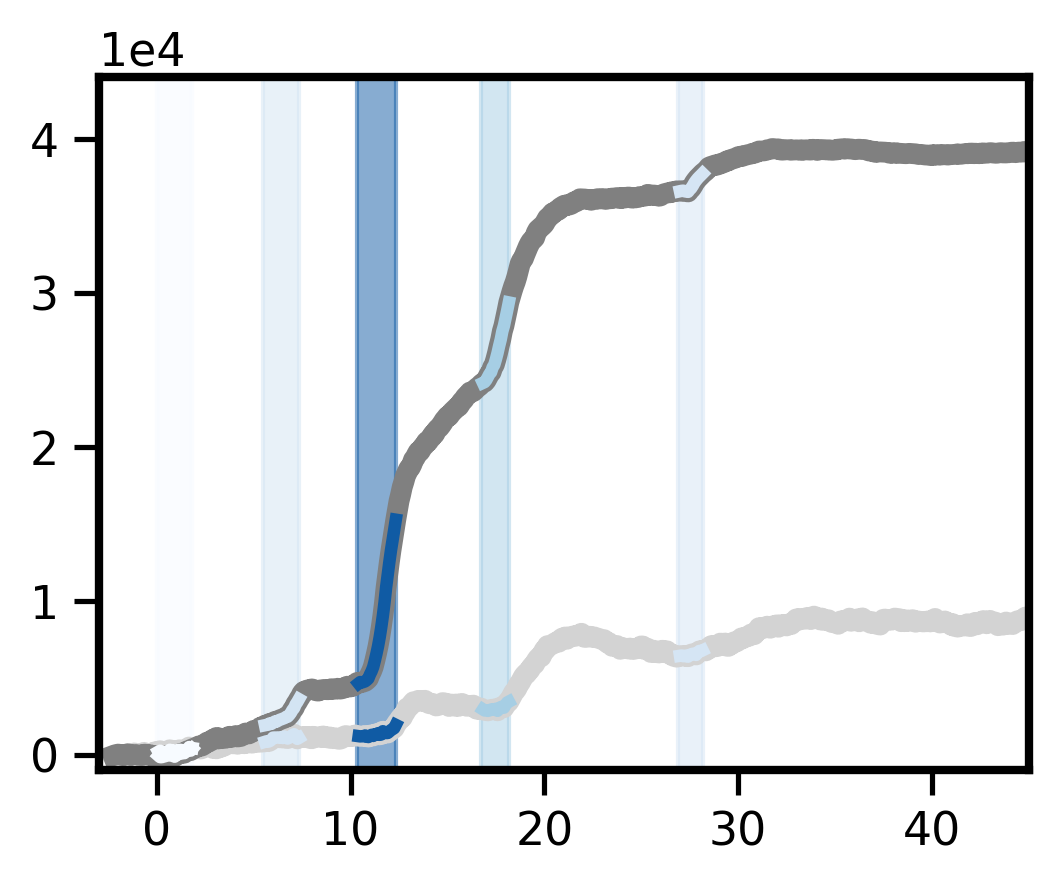

In [13]:
norma = plt.Normalize(25000, 300000)
#palette = LinearSegmentedColormap.from_list('what', ['#4B4B4B', '#DBD08F','#BC2313'])
palette = sns.color_palette("Blues",as_cmap=True)
colors = [palette(norma(size)) for size in event_areas]

fig, ax1 = plt.subplots(figsize=(4,3), dpi=300)
ax1.plot(coll_timepoints,radial_collection, 'lightgrey', linewidth=5)
ax1.plot(coll_timepoints,radial_collection_inside, 'grey', linewidth=5)

y_scale = max(radial_collection) * 1.1

for clID, clr, strstp in zip(clIDs, colors, event_start_stops):
    rel_time = np.array(coll_timepoints[strstp[0]:strstp[1]])-(5.0/60.0)*start_integration_t
    rel_rad_coll = np.array(radial_collection[strstp[0]- start_integration_t: strstp[1]- start_integration_t])
    ax1.plot(rel_time,rel_rad_coll, color=clr, linewidth=3)
    ax1.fill_betweenx([-1000,40000*1.1], (5.0/60.0)*(strstp[0] - swarm_start), (5.0/60.0)*(strstp[1] - swarm_start), alpha=0.5, color=clr)

for clID, clr, strstp in zip(clIDs, colors, event_start_stops):
    rel_time = np.array(coll_timepoints[strstp[0]:strstp[1]])-(5.0/60.0)*start_integration_t
    rel_rad_coll = np.array(radial_collection_inside[strstp[0]- start_integration_t: strstp[1]- start_integration_t])
    ax1.plot(rel_time,rel_rad_coll, color=clr, linewidth=3)
    #ax1.fill_betweenx([-1000,40000], (5.0/60.0)*(strstp[0] - swarm_start), (5.0/60.0)*(strstp[1] - swarm_start), alpha=0.5, color=clr)


#plt.vlines(wave_start_times_real, ymin=-2, ymax=40000, linestyles='--', colors='grey')
plt.xlim(-3,45)
plt.ylim(-1000,40000*1.1)
#plt.colorbar(cm.ScalarMappable(norm=norma, cmap=palette))
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.savefig('fig4-79-accumulation-radial-movement-v-time-w-wave-area-outside-v-inside.png', dpi=300, bbox_inches='tight')